# [For Beginners] Tackling Toxic Using Keras
https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras

이 노트북은 Keras LSTM을 사용하여 분류문제를 해결합니다.

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


파일을 불러옵니다.

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

데이터의 상위 5개 행을 살펴봅니다.

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


흔한 전처리 방식 중 하나는 결측치를 확인하고 채우는 것입니다. 

In [4]:
train.isnull().any() , test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

결측치가 없어 처리할 필요는 없는 것 같습니다.

데이터셋에 대한 많은 전처리와 피쳐 엔지니어링을 진행해야 하지만, 우리의 목적은 전처리가 아닙니다. 따라서 작동할 수 있는 최소한의 처리만 진행하겠습니다.

이어서, 데이터셋에서 반응 변수를 분리하겠습니다.

In [5]:
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[list_classes].values
list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']

우리가 취하고 있는 접근 방식은 신경망의 일부로 LSTM에 내용을 전달하는 것이지만, 우리는 단어를 그대로 전달할 수 없습니다.

따라서 우리가 해야할 일은 다음과 같습니다:
1. 토큰화 - 문장을 개별 단어로 쪼갭니다. 예를 들어 'I love cats and love dogs'는 ['I','love','cats','and','dogs]가 됩니다.
2. 인덱싱 - 단어에 딕셔너리 형태로 인덱싱을 합니다. 예){1:'I',2:'love',3:'cats',4:'and',5:'dog'}
3. 인덱스 표현 - 문장의 단어 순서를 인덱스 형식으로 나타낼 수 있으며, 이를 LSTM에 제공할 수 있습니다. 예) [1,2,3,4,2,5]

운이 좋게도 케라스에서는 이를 쉽게 만들어줍니다. 우리는 문장을 토큰화할 때 고유 단어의 수만 정의해주면 됩니다.

In [6]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokened_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokened_test = tokenizer.texts_to_sequences(list_sentences_test)

단어와 인덱스가 딕셔너리 안에 저장된 것을 확인할 수 있습니다.

In [7]:
tokenizer.word_counts

OrderedDict([('explanation', 1771),
             ('why', 17818),
             ('the', 496540),
             ('edits', 9957),
             ('made', 9678),
             ('under', 7001),
             ('my', 45619),
             ('username', 1823),
             ('hardcore', 166),
             ('metallica', 35),
             ('fan', 1025),
             ('were', 15421),
             ('reverted', 3902),
             ('they', 27318),
             ("weren't", 424),
             ('vandalisms', 38),
             ('just', 27806),
             ('closure', 88),
             ('on', 89968),
             ('some', 22586),
             ('gas', 331),
             ('after', 8490),
             ('i', 204397),
             ('voted', 302),
             ('at', 39545),
             ('new', 10665),
             ('york', 912),
             ('dolls', 24),
             ('fac', 321),
             ('and', 224192),
             ('please', 29780),
             ("don't", 22917),
             ('remove', 5140),
          

In [8]:
    tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

'list_tokenized_train'은 인덱스의 형태로 만들어짐을 알 수 있습니다.

In [9]:
list_tokened_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

그러나 아직 하나의 문제가 남았습니다. 어떤 댓글은 매우 긴 반면, 하나의 단어로 이루어진 댓글도 있습니다. 예를 들면 다음과 같습니다:

Comment #1: [8,9,3,7,3,6,3,6,2,3,4,9]

Comment #2: [1,2]

따라서 일관된 길이(고정된 피쳐 수)를 가진 데이터를 제공해야 합니다.

이것이 '패딩'을 사용하는 이유입니다. 부족한 부분을 0으로 채워 짧은 문장을 다른 문장들처럼 만들 수 있었습니다. 반면, 최대 길이를 넘어가는 문장은 최대 길이로 잘라야 합니다. 이 경우 최대 길이는 200으로 설정했습니다.


In [10]:
maxlen = 200
X_t = pad_sequences(list_tokened_train, maxlen=maxlen)
X_te = pad_sequences(list_tokened_test, maxlen=maxlen)

가장 좋은 "최대길이"는 어떻게 설정할까요? 만약 너무 짧게 한다면 유용한 정보를 잃어 점수가 낮아질 수 있습니다. 너무 길게 한다면, LSTM 셀이 가능한 값과 정보들을 담기 위해 매우 커질 것입니다.

문장들의 길이 분포를 살펴보는 것이 하나의 방법이 되겠습니다.

In [11]:
totalNumWords = [len(one_comment) for one_comment in list_tokened_train]

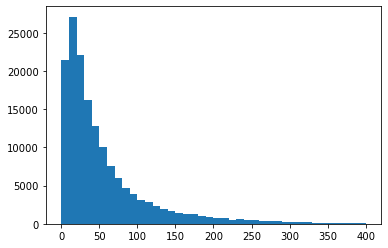

In [12]:
plt.hist(totalNumWords, bins = np.arange(0,410,10))
plt.show()

위 그림에서 알 수 있듯이, 대부분의 문장 길이는 30+ 입니다. 'maxlen'을 50으로 설정할 수 있지만, 넉넉하게 설정했습니다. 200이 아닌 다른 숫자를 사용하여 더 좋은 결과를 기대해볼 수도 있습니다.

__모델 구축__

다음은 우리가 구축할 모델의 구조입니다. 

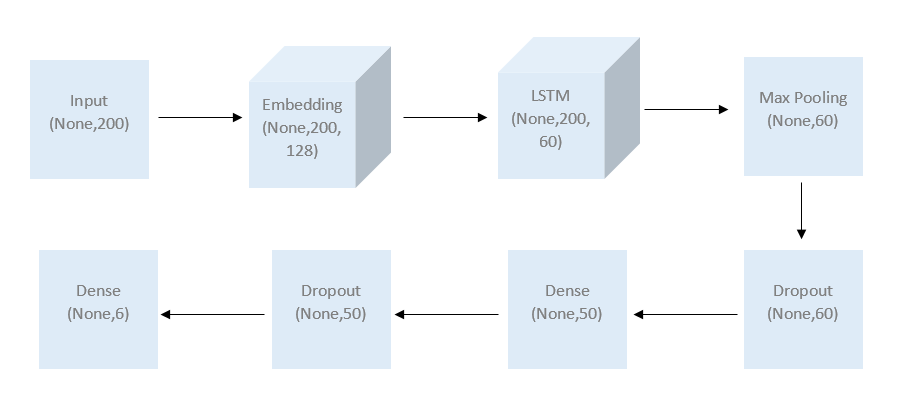

In [13]:
from IPython.display import Image
 
Image("architecture.png")

위에서 언급했던 것처럼 입력값은 인코딩된 문장입니다. 차원이 200인 문장을 받아들이는 input layer를 정의합니다.

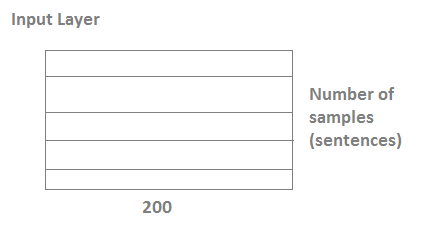

In [14]:
from IPython.display import Image
 
Image("input_layer.png")

,(comma)뒤를 공백으로 지시함으로써 케라스가 자동으로 숫자를 추론하게끔 합니다.

In [15]:
inp = Input(shape=(maxlen, )) 

다음으로, 이를 임베딩 레이어로 전달하며, 문장에서 주변 단어의 거리에 따라 정의된 벡터 공간에 단어를 투영합니다. 임베딩을 사용하면 모델 크기를 줄일 수 있으며, 가장 중요한 것은 문장의 단어를 표현하기 위해 원핫 인코딩을 사용하는 경우 처리해야 하는 차원을 엄청 줄일 수 있습니다. 

임베딩 레이어의 결과는 이 벡터 공간 내부의 단어의 좌표 리스트입니다. 예를 들어 (-81.012)는 'cat'이고 (-80.012)는 'dog'입니다. 또한 이러한 좌표들을 사용하여 관련성과 문맥을 감지합니다. 

우리는 '벡터 공간'의 사이즈와 고유 단어 수(max_features)를 정의해야 합니다. 임베딩 사이즈는 파라미터로 조절할 수 있습니다.

In [16]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

임베딩 레이어의 결과는 (None, 200, 128)의 3D 텐서입니다. 각각은 단어의 어레이(None은 사이즈가 케라스에 의해 추론됨을 의미합니다.), 각 단어(200), 임베딩의 벡터 공간에 128개의 좌표 어레이가 있음을 의미합니다.

이 텐서를 LSTM 레이어에 전달합니다. LSTM이 60차원과 결과가 펼쳐진 시퀀스로 나오게 설정합니다. 아시다시피 LSTM또는 RNN은 이전 네트워크의 출력을 입력으로 다시 제공하며, X번의 반복 후에 최종 출력을 취합니다. 그러나 사용 방법에 따라, 각 반복의 출력을 결과로 가져와 다음 계층으로 전달할 수 있습니다. 다음 그림에 이가 나타나있습니다.

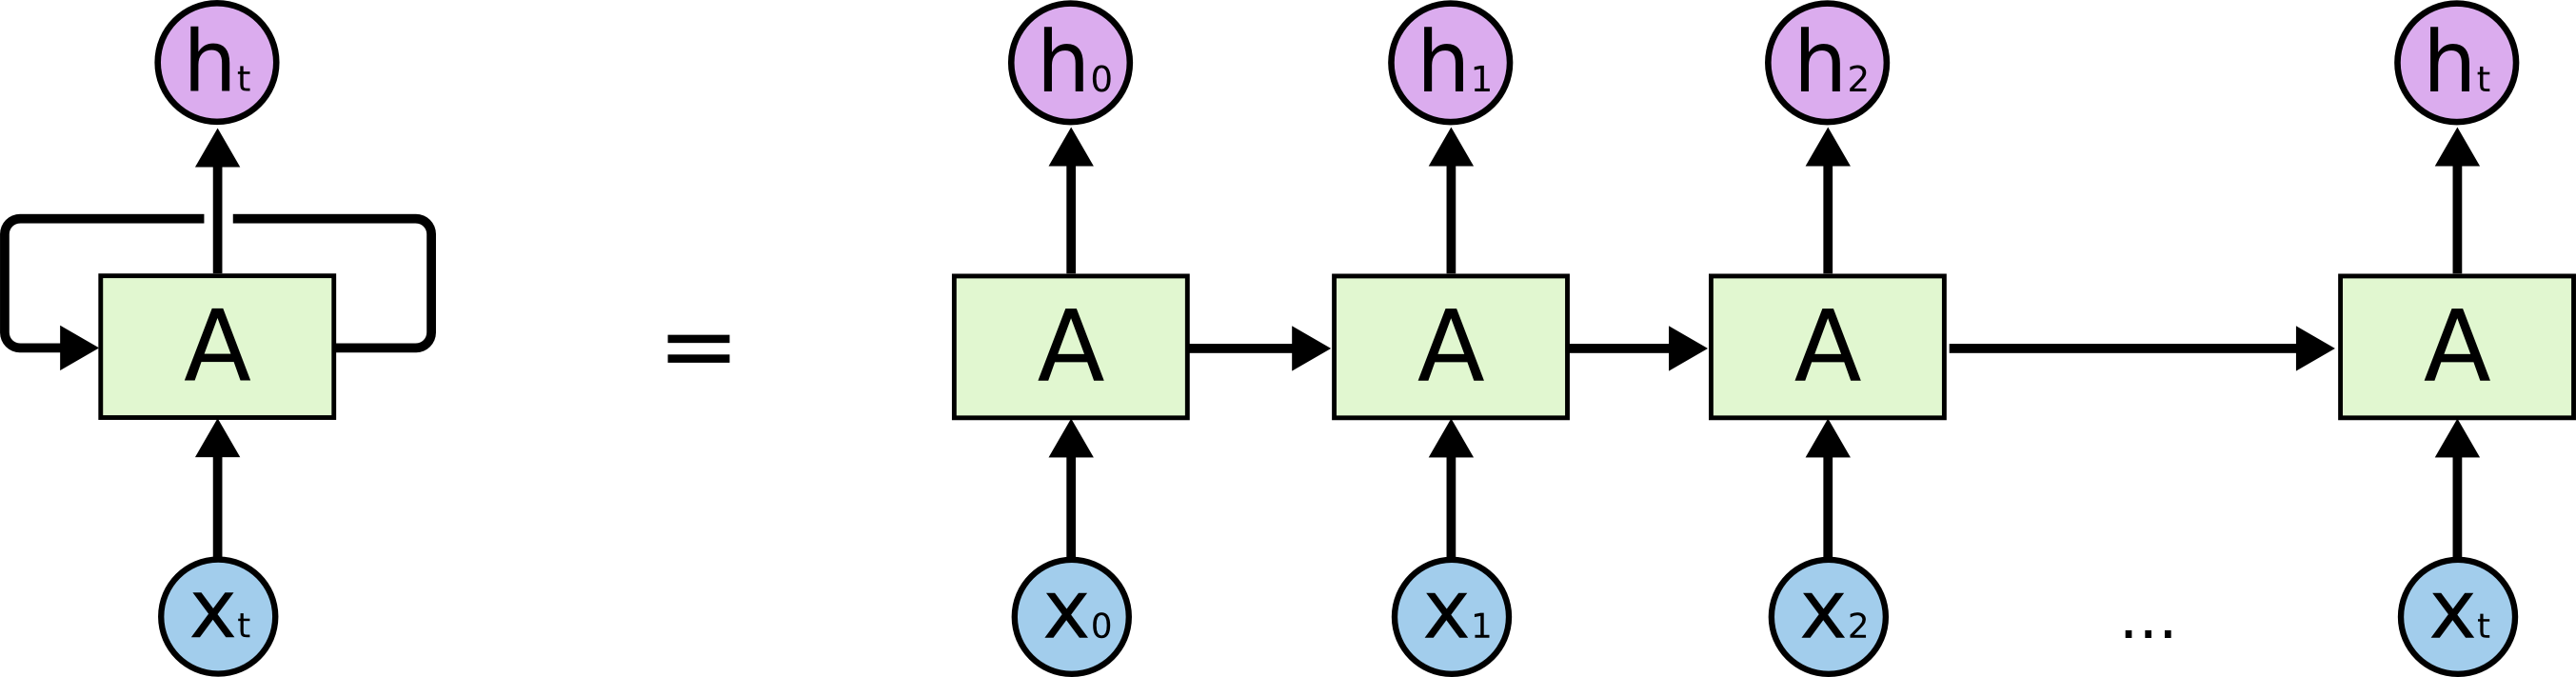

In [17]:
from IPython.display import Image
 
Image("RNN-unrolled.png")

위 사진에서 보시다시피, 펼쳐진 LSTM은 일련의 h0부터 h까지 제공합니다.

LSTM 레이어를 정의할 때, 입력 차원이 요구됩니다. LSTM은 [배치 사이즈, 타임 스텝, 인풋 개수]의 텐서 형태를 가집니다. 배치 사이즈는 배치의 샘플 수를 의미하고, 타임 스텝은 각 인풋을 수행할 때 몇 번의 반복을 진행하는지 또는 위 그림에서 'A'의 수로 나타낼 수 있습니다. 마지막으로 인풋 개수는 위 그림에서는 'x'를 의미하며, 변수의 개수(우리 케이스의 경우 문장 내 단어의 개수)입니다.

이전 3D 텐서 형태(None, 200, 128)의 임베딩 레이어의 결과를 LSTM에 사용합니다. 샘플을 통해 LSTM 모델을 200번 반복 실행하고 매번 단어의 좌표를 전달합니다. 펼쳐진 버전이기 때문에 (None, 200, 60)의 텐서 형태를 받습니다. 60은 우리가 정의한 결과의 차원입니다.

In [18]:
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

일반 레이어에 전달하기 전에, 3D 텐서를 2D로 바꿔야 합니다. 데이터를 날리지 않게 reshape을 조심스럽게 해야하며, 이상적으로는 결과 데이터가 원본데이터를 잘 나타내는 것입니다.

그러므로 CNN 문제에서이미지 데이터의 차원을 줄이는 전통적인 방법인 Global Max Pooling layer를 사용합니다. 간단히 말해서, 각 데이터 패치를 검토하고 각 패치의 최대값을 취합니다. 최대값의 모음은 우리가 사용할 수 있는 축소된 데이터 집합입니다.

In [20]:
x = GlobalMaxPool1D()(x)

레이어의 노드가 누락된 데이터 표현을 처리하여 전체 네트워크가 더 나은 결과를 가져올 수 있도록 일부 노드를 무차별적으로 '비활성화'하는 드롭아웃 레이어에 2D 텐서를 전달합니다.

노드의 10%를 비활성화 하는 드롭아웃 레이어를 만듭니다.

In [21]:
x = Dropout(0.1)(x)

레이어를 드롭한 후에 이를 dense 레이어에 연결하고 RELU 함수를 통과시킵니다.

__Activation((Input x Weights) + Bias)__

Dense 레이어의 차원은 50으로 설정합니다.

In [22]:
x = Dense(50, activation='relu')(x)

한번더 드롭아웃을 진행합니다.

In [23]:
x = Dropout(0.1)(x)

마지막으로, 시그모이드 레이어에 전달합니다. 시그모이드를 사용하는 이유는 6개의 각 라벨에 대해이진 분류(1,0)를 하기 때문입니다. 시그모이드 함수는 결과를 0과 1사이의 범위로 변환합니다.

In [24]:
x = Dense(6, activation='sigmoid')(x)

거의 다 왔습니다. 남은 것은 입/출력값과 교육 과정을 정의하는 것입니다. Adam optimizer을 이용하여 손실 함수를 최적화 하는 모델을 설정합니다. 그리고 손실함수는 이진 분류를 하기 때문에 'binary_crossentropy'입니다. learning rate의 디폴트는 0.001입니다.

In [25]:
model = Model(inputs = inp, outputs=x)
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

이제 모델을 테스트할 시간입니다. 각 배치당 32개의 패딩과 인덱싱이 된 문장을 전달하고, 10% 데이터를 검증에 사용합니다. 검증 셋을 통해 각 배치가 과적합이 됐는지 평가할 수 있습니다. 모델은 2번 반복됩니다(2 epochs). 여러 파라미터를 직접 튜닝하여 더 좋은 모델을 만들 수 있습니다.

In [26]:
batch_size = 32
epochs = 2
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 115s 26ms/step - loss: 0.0693 - accuracy: 0.9572 - val_loss: 0.0504 - val_accuracy: 0.9939
Epoch 2/2
4488/4488 [==============================] - 115s 26ms/step - loss: 0.0454 - accuracy: 0.9820 - val_loss: 0.0497 - val_accuracy: 0.9939


__추가 팁과 트릭__

1) 차원 관련 오류를 만났다면, 'model.summary()'를 호출하는 것이 좋습니다. 왜냐하면 모든 레이어를 출력하기 때문에 진단에 매우 유용합니다.

In [27]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)               

2) 레이어를 추가하고 변환을 수행하는 동안, 예상대로 출력이 나오는지 확인하는 것이 좋습니다.

In [28]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape
# print layer_output to see the actual data

(1, 200, 60)